# QCoDeS Example with AMI430

## Summary of automated tests that the driver goes through

We have performed a lot of stand alone tests (tests with mocked hardware) in `tests/test_ami430_visa.py`. In particular, we have tested: 
- If the driver remembers the internal setpoints if these are given in cartesian, spherical and cylindrical coordinates
- Check that we send to correct setpoint instructions to the individual instruments if inputs are cartesian, spherical or cylindrical coordinates
- Test that we can call the measured parameters (e.g. cartesian_measured) without exceptions occurring. 
- Check that instruments which need to ramp down are given adjustment instructions first
- Check that field limit exceptions are raised properly
- Check that the driver remembers theta and phi coordinates even if the vector norm is zero. 
- Test that a warning is issued when the maximum ramp rate is increased 
- Test that an exception is raised when we try to set a ramp rate which is higher then the maximum allowed value.

Furthermore, in `tests/test_field_vector.py` we have tested if the cartesian to spherical/cylindrical coordinate transformations and visa-versa has been correctly implemented by asserting symmetry rules. 

## Connecting to the individual axis instruments

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np

from qcodes.instrument_drivers.american_magnetics import AMIModel430, AMIModel4303D
from qcodes.math_utils.field_vector import FieldVector

In [2]:
# Check if we can establish communication with the power sources
ix = AMIModel430("x", address="TCPIP0::169.254.146.116::7180::SOCKET")
iy = AMIModel430("y", address="TCPIP0::169.254.136.91::7180::SOCKET")
iz = AMIModel430("z", address="TCPIP0::169.254.21.127::7180::SOCKET")

Connected to: AMERICAN MAGNETICS INC. 430 (serial:2.01, firmware:None) in 0.60s
Connected to: AMERICAN MAGNETICS INC. 430 (serial:2.01, firmware:None) in 0.62s
Connected to: AMERICAN MAGNETICS INC. 430 (serial:2.01, firmware:None) in 0.57s


## Working with a single axis

On individual instruments (individual axes), we:

- Test that we can correctly set current values of individual sources
- Test that we can correctly measure current values of individual sources 
- Test that we can put the sources in paused mode 
- Test that the ramp rates are properly set 

In [3]:
# lets test an individual instrument first. We select the z axis.
instrument = iz

# Since the set method of the driver only excepts fields in Tesla and we want to check if the correct
# currents are applied, we need to convert target currents to target fields. For this reason we need
# the coil constant.
coil_const = instrument._coil_constant
current_rating = instrument._current_rating
current_ramp_limit = instrument._current_ramp_limit
print(f"coil constant = {coil_const} T/A")
print(f"current rating = {current_rating} A")
print(f"current ramp rate limit = {current_ramp_limit} A/s")

coil constant = 0.076 T/A
current rating = 79.1 A
current ramp rate limit = 0.06 A/s


In [5]:
# Let see if we can set and get the field in Tesla
target_current = 1.0  # [A]  The current we want to set
target_field = coil_const * target_current  # [T]
print(f"Target field is {target_field} T")
instrument.field(target_field)

field = instrument.field()  # This gives us the measured field
print(f"Measured field is {field} T")
# The current should be
current = field / coil_const
print(f"Measured current is = {current} A")
# We have verified with manual inspection that the current has indeed ben reached

Target field is 0.076 T
Measured field is 0.07604 T
Measured current is = 1.0005263157894737 A


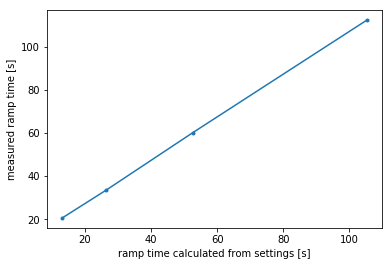

slope = 0.9993355432517128. A value close to one means the correct ramp times are used
offset = 7.364001916301564. An offset indicates that there is a fixed delay is added to a ramp request


In [24]:
# Verify that the ramp rate is indeed how it is specified
ramp_rate = instrument.ramp_rate()  # get the ramp rate
instrument.field(0)  # make sure we are back at zero amps

target_fields = [0.1, 0.3, 0.7, 1.5]  # [T]
t_setting = []
t_actual = []

for target_field in target_fields:
    current_field = instrument.field()
    ts = abs(target_field - current_field) / ramp_rate
    t_setting.append(ts)

    tb = time.time()
    instrument.field(target_field)
    te = time.time()
    ta = te - tb
    t_actual.append(ta)

fig, ax = plt.subplots()
ax.plot(t_setting, t_actual, ".-")
plt.xlabel("ramp time calculated from settings [s]")
plt.ylabel("measured ramp time [s]")
plt.show()
slope, offset = np.polyfit(t_setting, t_actual, 1)
print(f"slope = {slope}. A value close to one means the correct ramp times are used")
print(
    f"offset = {offset}. An offset indicates that there is a fixed delay is added to a ramp request"
)

In [9]:
# Lets move back to zero Amp
instrument.field(0)

### Note on maximum current ramp rate

The maximum current ramp rate can be increased to a desired value via setting the `current_ramp_limit` parameter. However, this should be done conservatively to avoid quenching the magnet. We strongly recommend to consult to the manual of your particular magnet before making any changes.

## Working with the 3D driver, controlling all 3 axes

With the 3D driver, we:

- Test that the correct set points are reached if we give inputs in cartesian, spherical or cylindrical coordinates 
- Test that we can set theta and phi to non-zero values which are remembered if r is ramped from zero to r > 0. 
- Test that instruments are ramped up and down in the correct order, with ramp downs occuring before ramp ups.


In [3]:
def field_is_along_z_and_less_that_3_t(x, y, z):
    # We can have higher field along the z-axis if x and y are zero.
    return x == 0 and y == 0 and z < 3


def field_is_less_than_2_t(x, y, z):
    return np.linalg.norm([x, y, z]) < 2


# Lets test the 3D driver now.
field_limit = [  # If any of the field limit functions are satisfied we are in the safe zone.
    field_is_along_z_and_less_that_3_t,
    field_is_less_than_2_t,
]

i3d = AMIModel4303D("AMI430_3D", ix, iy, iz, field_limit=field_limit)

In [4]:
def current_to_field(name, current):
    """We cannot set currents directly, so we need to calculate what fields need to be generated for
    the desired currents"""
    instrument = {"x": ix, "y": iy, "z": iz}[name]
    coil_constant = instrument._coil_constant  #  [T/A]
    field = current * coil_constant
    return field

In [12]:
# Lets see if we can set a certain current using cartesian coordinates
current_target = [1.0, 0.5, 1.5]
# calculate the fields needed
field_target = [current_to_field(n, v) for n, v in zip(["x", "y", "z"], current_target)]
print(f"field target = {field_target}")
i3d.cartesian(field_target)
field_measured = i3d.cartesian_measured()
print(f"field measured = {field_measured}")

field target = [0.0386, 0.0121, 0.11399999999999999]
field measured = [0.03816, 0.01211, 0.11384]


In [13]:
# Lets move back to 0,0,0
i3d.cartesian([0, 0, 0])

# Lets see if we can set a certain current using spherical coordinates
current_target = [1.0, 0.5, 1.5]
# calculate the fields needed
field_target_cartesian = [
    current_to_field(n, v) for n, v in zip(["x", "y", "z"], current_target)
]
# calculate the field target in spherical coordinates
field_target_spherical = FieldVector(*field_target_cartesian).get_components(
    "r", "theta", "phi"
)

print(f"field target = {field_target_spherical}")
i3d.spherical(field_target_spherical)
field_measured = i3d.spherical_measured()
print(f"field measured = {field_measured}")
# Like before, we see that the current target of 1.0, 0.5, 1.5 A for x, y and z have indeed been reached

field target = [0.1209643335863923, 19.536859161547078, 17.404721375291402]
field measured = [0.12077462481829535, 19.424782613847988, 17.532727661391853]


In [15]:
# Lets move back to 0,0,0
i3d.cartesian([0, 0, 0])

# Lets see if we can set a certain current using cylindrical coordinates
current_target = [1.0, 0.5, 1.5]
# calculate the fields needed
field_target_cartesian = [
    current_to_field(n, v) for n, v in zip(["x", "y", "z"], current_target)
]
# calculate the field target in cylindrical coordinates
field_target_cylindrical = FieldVector(*field_target_cartesian).get_components(
    "rho", "phi", "z"
)

print(f"field target = {field_target_cylindrical}")
i3d.cylindrical(field_target_cylindrical)
field_measured = i3d.cylindrical_measured()
print(f"field measured = {field_measured}")
# Like before, we see that the current target of 1.0, 0.5, 1.5 A for x, y and z have indeed been reached

field target = [0.040452070404368677, 17.404721375291402, 0.11399999999999999]
field measured = [0.040235668255914431, 17.51627743673798, 0.11365]


In [16]:
# Test that ramping up and down occurs in the right order,
# that is, first, ramp axes that have ramp down,
# and only then ramp axes that have to ramp up.
current_target = [1.0, 0.75, 1.0]  # We ramp down the z, ramp up y and keep x the same
# We should see that z is adjusted first, then y.
# calculate the fields needed
field_target = [current_to_field(n, v) for n, v in zip(["x", "y", "z"], current_target)]
print(f"field target = {field_target}")
i3d.cartesian(field_target)
# Manual inspection has shown that z is indeed ramped down before y is ramped up

field target = [0.0386, 0.01815, 0.076]


In [17]:
# check that an exception is raised when we try to set a field which is out side of the safety limits
try:
    i3d.cartesian([2.1, 0, 0])
    print("something went wrong... we should not be able to do this :-(")
except Exception:
    print("error successfully raised. The driver does not let you do stupid stuff")

error successfully raised. The driver does not let you do stupid stuff


In [25]:
# Check that the driver remembers theta/phi values if the set point norm is zero

# lets go back to zero field
i3d.cartesian([0, 0, 0])
# Lets set theta and phi to a non zero value but keep the field magnitude at zero
field_target_spherical = [0, 20.0, -40.0]
i3d.spherical(field_target_spherical)
field_measured = i3d.cartesian_measured()
print(f"1: Measured field = {field_measured} T")

# Note that theta_measured and phi_measured will give random values based on noisy current reading
# close to zero (this cannot be avoided)
theta_measured = i3d.theta_measured()
print(f"1: Theta measured = {theta_measured}")
phi_measured = i3d.phi_measured()
print(f"1: Phi measured = {phi_measured}")

# now lets set the r value
i3d.field(0.4)

field_measured = i3d.cartesian_measured()
print(f"2: Measured field = {field_measured} T")
# Now the measured angles should be as we intended
theta_measured = i3d.theta_measured()
print(
    f"2: Theta measured = {theta_measured}. We see that the input theta of {field_target_spherical[1]} has been "
    "remembered"
)

phi_measured = i3d.phi_measured()
print(
    f"2: Phi measured = {phi_measured}. We see that the input phi of {field_target_spherical[2]} has been "
    "remembered"
)

1: Measured field = [-0.00013, -1e-05, 3e-05] T
1: Theta measured = 98.72079692816342
1: Phi measured = 180.0
2: Measured field = [0.10484, -0.08797, 0.37558] T
2: Theta measured = 20.032264760097508. We see that the input theta of 20.0 has been remembered
2: Phi measured = -40.007172479040996. We see that the input phi of -40.0 has been remembered


### Simultaneous ramping mode

The 3D driver has a ``ramp_mode`` parameter whose default value is ``"default"``. In this mode, the ramping of all the 3 axes is sequential e.g. first X axis is ramped until its setpoint, then Y axis, then Z axis. In order to ramp all the three axis together, simultaneously, there exists another ramp mode called ``"simultaneous"``:

In [ ]:
i3d.ramp_mode("simultaneous")

Thanks to all there axes instruments being swept together, the magnetic field changes along the vector from the current/initial field value towards the setpoint value. Use the simultaneous mode either by setting ``vector_ramp_rate`` parameter, or by calling ``ramp_simultaneously`` convenience method.

To return to the default ramp mode, set the ramp mode parameter to ``"default"``:

In [ ]:
i3d.ramp_mode("default")

``vector_ramp_rate`` parameter corresponds to the desired ramp rate along the vector from the current magnetic field value to the setpoint value. To initiate the ramp, use any of the already familiar parameters that set the field setpoint value, e.g. ``i3d.cartesian([0.1, 0.2, 0.3])``. Use the ``vector_ramp_rate`` approach if you would like to sweep all axes simultaneously *at a given ramp rate along the vector towards the setpoint value*:

In [ ]:
i3d.ramp_mode("simultaneous")
i3d.vector_ramp_rate(0.05)  # requires all axes to have same ramp rate units!!!
x = 0
y = 0
z = 0
i3d.cartesian((x, y, z))  # or any other parameter call that initiates a ramp

The ``vector_ramp_rate`` parameter assumes that the given value is in the same ramp units as the units of all the three individual axis instruments. If not all axis instruments have the same ramp rate units, an exception will be raised.

``ramp_simultaneously`` method takes the sweep duration as it's argument, and uses it to calculate the corresponding vector ramp rate, and initiate the ramp. Use the ``ramp_simultaneously`` approach if you would like to sweep all axes simultaneously *in a given time* along the vector towards the setpoint value:

In [ ]:
i3d.ramp_simultaneously(setpoint=FieldVector(0.5, 1.0, 0.01), duration=2)
# See the docstring of this method for details

The ``ramp_simultaneously`` method assumes that the given setpoint value as well as the given duration are in the same units as the units of all the three individual axis instruments. If not all axis instruments have the same units for ramp rate and field, an exception will be raised.

If ``block_during_ramp`` parameter is set to ``False``, then the call that initiated the ramp (either ``ramp_simultaneously`` or call to a field setpoint parameter) will return right after the ramp is initiated. Otherwise, the calls will block until the ramp is complete (that is, until all 3 axes stopped ramping).

In [ ]:
i3d.block_during_ramp(False)

The driver comes with convenient methods that can be used in the measurement code to implement checks for completion of the ramping process (e.g. for waiting until the ramping is complete): ``i3d.wait_while_all_axes_ramping`` that blocks until the ramping is complete (check that ramping state every ``i3d.ramping_state_check_interval`` seconds), and ``i3d.any_axis_is_ramping`` that returns ``True``/``False`` based on whether the ramping is still in process or completed.

In [ ]:
i3d.any_axis_is_ramping()

In [ ]:
i3d.wait_while_all_axes_ramping()

In [ ]:
i3d.ramping_state_check_interval(0.5)

**NOTE** that ramping with the ``"simultaneous"`` mode changes the ramp rates of the individual magnet axes. The implementation is such that, given the current and the setpoint magnetic field vectors together with either vector ramp rate (``vector_ramp_rate`` parameter) or the desired ramp duration (``ramp_simultaneously`` method), the required ramp rates of the individual axes are calculated and then set via the ``ramp_rate`` parameters of the individual magnet axes. Once the individual ramp rates are set to new values, the ramping is initiated on all axes (almost) at the same time. However, the values of the individual ramp rates can be **restored** by calling ``wait_while_all_axes_ramping``. It is advised to call ``wait_while_all_axes_ramping`` especially for non-blocking ramps (``block_during_ramp`` parameter set to ``False``) as not only your code waits for the ramp to finish but also ensures that the magnet is in a known good (original) state before doing the next operation. Note that if ``block_during_ramp`` parameter is set to ``True``, ``wait_while_all_axes_ramping`` method is called automatically by the ramping logic, thus the ramp rates of the individual magnet axes are **restored** after the ramp is finished. Below is an example of performing a non-blocking simultaneous ramp (with ``block_during_ramp`` parameter set to ``False``) and using ``wait_while_all_axes_ramping`` to wait for the ramp to finish and also to restore the ramp rates of the individual magnet axes:

```python
# Let's assume that these are the original values
# of the ramp rates of the individual axes
ix.ramp_rate(0.01)
iy.ramp_rate(0.02)
iz.ramp_rate(0.03)

# And let's assume that for this measurement we
# don't want the ramp calls to block, but we DO
# want to restore the original values of the ramp
# rates of the inidividual axes
i3d.block_during_ramp(False)

# Starting the ramp will change the values of the ramp rates 
# of the individual axes
i3d.ramp_simultaneously(setpoint=FieldVector(0.5, 1.0, 0.01), duration=2)

# .. or initiate the ramp using ``vector_ramp_rate`` with
# a field setpoint parameter
# i3d.vector_ramp_rate(0.34)
# i3d.cartesian((0.5, 1.0, 0.01))

# ...
# Here comes your code of the measurement that you'd like to do
# while the magnet ramping
# ...

# Here the ramp rates of the individual axes are still different
# from their original values
assert ix.ramp_rate() != 0.01
assert iy.ramp_rate() != 0.02
assert iz.ramp_rate() != 0.03

# And now, let's wait for the ramping to finish which will also
# restore the ramp rates of the individual magnet axes to their
# original values
i3d.wait_while_all_axes_ramping()

# So here, the ramp rates of the individual axes are already
# restored to their original/initial values
assert ix.ramp_rate() == 0.01
assert iy.ramp_rate() == 0.02
assert iz.ramp_rate() == 0.03
```

For user convenience, the calculation methods between vactor ramp rate, sweep duration, and individual ramp rates for axes are exposed: see ``i3d.calculate_axes_ramp_rates_from_vector_ramp_rate``, ``i3d.calculate_vector_ramp_rate_from_duration``, ``i3d.calculate_axes_ramp_rates_for`` methods.

Use the ``i3d.pause`` method to request all three axes instruments to pause ramping:

In [ ]:
i3d.pause()

Note that the results of testing on the real instruments show that:
- if the requested field change is 0 for one/two/all-three axes, ramping still "simply works", e.g. the instrument attempts to ramp, finds that it's already in the right place, and stops ramping
- if the requested field change for a given axis results in a ramp rate that is less than minimal ramp rate, the instrument still ramps to the corresponding setpoint value at some small ramp rate
- when a ramp rate of an individual magnet axis is changed during an ongoing ramp (started without blocking), the ramp rate is in fact changed on the fly for the active ramp

## Dond while ramping 

Lets now look at how the simultaneous ramp mode can be integrated with a typical measurement. The idea is to start the ramp and then do a dond scan with a fixed delay until the ramp is completed.

In [ ]:
import time

import xarray as xr

from qcodes.dataset import LinSweep, dond, load_or_create_experiment
from qcodes.instrument_drivers.mock_instruments import (
    DummyInstrument,
    DummyInstrumentWithMeasurement,
)
from qcodes.parameters import ElapsedTimeParameter

In [ ]:
# preparatory mocking of physical setup
dac = DummyInstrument("dac", gates=["ch1", "ch2"])
dmm = DummyInstrumentWithMeasurement("dmm", setter_instr=dac)

In [ ]:
tutorial_exp = load_or_create_experiment("doNd_while_ramping", sample_name="no sample")

In [ ]:
sweep_1 = LinSweep(dac.ch1, 0, 1, 5, 0)
sweep_2 = LinSweep(dac.ch2, 0, 1, 10, 0)

In [ ]:
time_p = ElapsedTimeParameter("time")

In [ ]:
zero_field = FieldVector(x=0.0, y=0.0, z=0.0)
zero_field

FieldVector(x=0.0, y=0.0, z=0.0)

In [ ]:
setpoint = FieldVector(x=0.02, y=0.02, z=0.02)
setpoint

FieldVector(x=0.02, y=0.02, z=0.02)

First we start with a example that is independent of the magnets but shows how we can measure a 2D scan as a function of time.
Note that we keep the timing logic minimal, so the points may not be equidistant in time. This can be extended if needed.

In [ ]:
elapsed_time = 0
timed_datasets = []

time_p.reset_clock()

while elapsed_time < 2:
    ds, _, _ = dond(sweep_1, sweep_2, dmm.v1, additional_setpoints=(time_p,))
    timed_datasets.append(ds)
    time.sleep(0.5)
    elapsed_time = time_p.get()

Starting experimental run with id: 205. Using 'qcodes.utils.dataset.doNd.dond'
Starting experimental run with id: 206. Using 'qcodes.utils.dataset.doNd.dond'
Starting experimental run with id: 207. Using 'qcodes.utils.dataset.doNd.dond'
Starting experimental run with id: 208. Using 'qcodes.utils.dataset.doNd.dond'


To visualize this lets merge the datasets using xarray

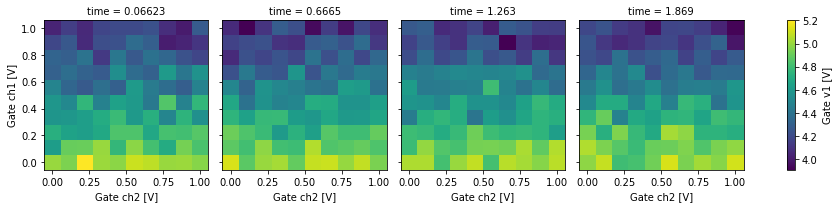

In [ ]:
timed_xarray_datasets = [ds.to_xarray_dataset() for ds in timed_datasets]
merged_dataset = xr.merge(timed_xarray_datasets)
merged_dataset.dmm_v1.plot(col="time")

Now, let's do the same but while also ramping the magnetic field. We'll use the ``ramp_simultaneously`` method here:

In [ ]:
ramp_datasets = []

# Required for ``ramp_simultaneously`` to return
# immediately after initiating a ramp
i3d.block_during_ramp(False)

# Assuming the field is in T and time in minutes
i3d.ramp_simultaneously(setpoint=setpoint, duration=2.0)

time_p.reset_clock()  # Let's also store the elapsed time

while i3d.any_axis_is_ramping():  # Should be clear without additional explanation ;)
    # Run the 2D scan measurement
    ds, _, _ = dond(
        sweep_1,
        sweep_2,
        dmm.v1,
        additional_setpoints=(time_p, ix.field, iy.field, iy.field),
    )

    # Collect the dataset for later processing
    ramp_datasets.append(ds)

    # Optionally, wait until the field changed sufficiently
    # enough for this measurement
    time.sleep(0.5)

Now the resulting ``ramp_datasets`` can be merged along time/field-x/field-y/field-z axes, as desired (see above), and used further, e.g. plotted.